In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud


In [6]:
file_path = 'data/model_annotations_liwc_h.xlsx'
dfm = pd.read_excel(file_path, engine='openpyxl')
dfm.head()

,text,proc_text,model_unanimous,Segment,WC,Analytic,Clout,Authentic,Tone,WPS,...,nonflu,filler,AllPunc,Period,Comma,QMark,Exclam,Apostro,OtherP,Emoji
0,"Dear World:family_man_woman_girl_boy:, you nee...","Dear World:family_man_woman_girl_boy:, you nee...",PO,1,32,52.84,75.49,1.63,1.00,16.0,...,0.0,0.0,59.38,3.13,6.25,0.0,0.0,0.00,50.00,12.5
1,.@fordnation says releasing the projection mod...,.@fordnation says releasing the projection mod...,PO,1,28,96.35,3.12,48.09,1.00,28.0,...,0.0,0.0,32.14,3.57,3.57,0.0,0.0,3.57,21.43,0.0
2,"""Neurologists around the world say that a smal...","""Neurologists around the world say that a smal...",UN,1,34,93.03,24.36,4.60,20.23,17.0,...,0.0,0.0,20.59,2.94,0.00,0.0,0.0,2.94,14.71,0.0
3,Coronavirus: More than one million cases confi...,Coronavirus: More than one million cases confi...,UN,1,34,93.03,40.06,12.44,1.85,17.0,...,0.0,0.0,14.71,5.88,0.00,0.0,0.0,0.00,8.82,0.0
4,"This is my Gov, @henrymcmaster, today, 4/2/202...","This is my Gov, @henrymcmaster, today, 4/2/202...",UN,1,42,81.45,54.27,72.58,3.20,10.5,...,0.0,0.0,38.10,7.14,11.90,0.0,0.0,2.38,16.67,0.0


In [7]:
print(dfm.columns.values)

['text' 'proc_text' 'model_unanimous' 'Segment' 'WC' 'Analytic' 'Clout'
 'Authentic' 'Tone' 'WPS' 'BigWords' 'Dic' 'Linguistic' 'function'
 'pronoun' 'ppron' 'i' 'we' 'you' 'shehe' 'they' 'ipron' 'det' 'article'
 'number' 'prep' 'auxverb' 'adverb' 'conj' 'negate' 'verb' 'adj'
 'quantity' 'Drives' 'affiliation' 'achieve' 'power' 'Cognition' 'allnone'
 'cogproc' 'insight' 'cause' 'discrep' 'tentat' 'certitude' 'differ'
 'memory' 'Affect' 'tone_pos' 'tone_neg' 'emotion' 'emo_pos' 'emo_neg'
 'emo_anx' 'emo_anger' 'emo_sad' 'swear' 'Social' 'socbehav' 'prosocial'
 'polite' 'conflict' 'moral' 'comm' 'socrefs' 'family' 'friend' 'female'
 'male' 'Culture' 'politic' 'ethnicity' 'tech' 'Lifestyle' 'leisure'
 'home' 'work' 'money' 'relig' 'Physical' 'health' 'illness' 'wellness'
 'mental' 'substances' 'sexual' 'food' 'death' 'need' 'want' 'acquire'
 'lack' 'fulfill' 'fatigue' 'reward' 'risk' 'curiosity' 'allure'
 'Perception' 'attention' 'motion' 'space' 'visual' 'auditory' 'feeling'
 'time' 'foc

In [8]:
target = dfm['model_unanimous']
dfm.drop(['model_unanimous'],inplace=True,axis=1)

## tfid vectorizing

In [9]:


X_train, X_test, y_train, y_test = train_test_split(dfm, target, test_size=0.2, random_state=42)

X_train_tweet = X_train["proc_text"]
X_test_tweet = X_test["proc_text"]
X_train.drop(['proc_text',"text"],inplace=True,axis=1)
X_test.drop(['proc_text',"text"],inplace=True,axis=1)

# Vectorizing the tweets
# vectorizer = CountVectorizer(stop_words='english')
tf_id_vectorizer = TfidfVectorizer(stop_words='english')
X_train_tweet_tfid = tf_id_vectorizer.fit_transform(X_train_tweet)
X_test_tweet_tfid = tf_id_vectorizer.transform(X_test_tweet)

In [10]:


# Generating TF-IDF vectors for visualization
texts = dfm['proc_text'].values
tfidf_matrix = X_train_tweet_tfid

# Converting TF-IDF matrix to dense format and getting feature names
tfidf_dense = tfidf_matrix.todense()
feature_names = tf_id_vectorizer.get_feature_names_out()

# Creating a DataFrame for easier manipulation
df_tfidf = pd.DataFrame(tfidf_dense, columns=feature_names)

In [11]:
# Summarizing the TF-IDF scores for each word across all documents to rank them
word_tfidf_sum = df_tfidf.sum().sort_values(ascending=False)

print(word_tfidf_sum.head(20))

coronavirus    372.279348
panic          367.206915
covid19        333.077420
don            171.895740
amp            164.862996
people         161.874644
covid_19       140.148427
hands          136.723301
shake          118.640937
pandemic       117.400552
stay           114.336493
covid          106.247582
chill          103.839694
shaking        100.910749
just            98.860785
buying          98.023724
need            89.124056
symptoms        88.639297
time            87.242647
home            84.627209
dtype: float64


In [12]:
# heatmap
# plt.figure(figsize=(12, 12))
# sns.heatmap(df_tfidf.iloc[:, :40], cmap='YlGnBu')
# plt.title('TF-IDF Scores Heatmap for Top 30 Words in All Documents')
# plt.xlabel('Top 30 Words')
# plt.ylabel('Documents')
# plt.show()

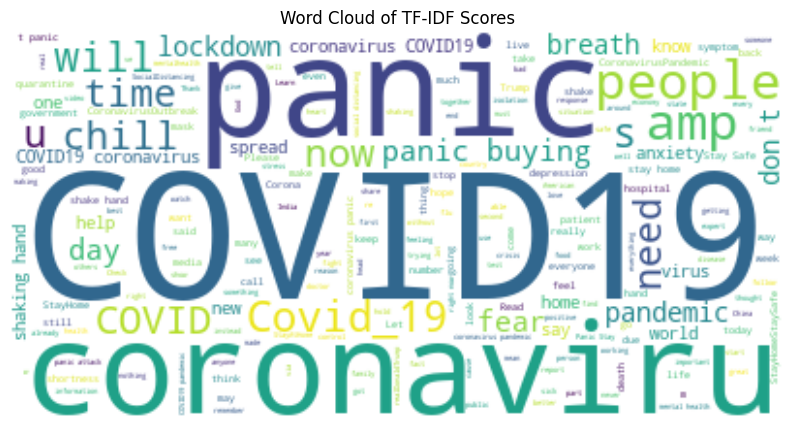

In [13]:
# word cloud
combined_texts = ' '.join(texts)
wordcloud = WordCloud(background_color='white', max_words=200).generate(combined_texts)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of TF-IDF Scores')
plt.show()

## bag of words

In [14]:
# Applying Bag of Words model on the processed text
count_vect = CountVectorizer(stop_words='english')
X_train_bow = count_vect.fit_transform(X_train_tweet)
X_test_bow = count_vect.transform(X_test_tweet)

# Converting BoW matrix to DataFrame for easier visualization
feature_names_bow = count_vect.get_feature_names_out()
df_bow = pd.DataFrame(X_train_bow.toarray(), columns=feature_names_bow)
# Displaying the shape of the BoW matrix and the first few rows of the DataFrame
df_bow_shape = df_bow.shape
print('Shape of Bag of Words Matrix:', df_bow_shape)
display(df_bow.head())

Shape of Bag of Words Matrix: (10142, 26828)


,00,000,00001,00001282051,000054,000094,0001,0002,00092,000s,...,ነው,ነገ,አንዳቅፍህ,ዛሬ,コロナウイルス,ー19,人权,沙特阿拉伯vs全球,香港,우리_장르_사람들은_다아는_한문장
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## word2vec

In [15]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

# Tokenizing the processed text
train_texts_tokenized = [word_tokenize(text) for text in X_train_tweet]
test_texts_tokenized = [word_tokenize(text) for text in X_test_tweet]

# Training a Word2Vec model
word2vec_model = Word2Vec(sentences=train_texts_tokenized, vector_size=100, window=5, min_count=1, workers=4)

# Summarizing the model
print('Word2Vec model trained.')
print('Vocabulary size:', len(word2vec_model.wv.key_to_index))

# Exploring word vectors
example_word = 'panic'
example_vector = word2vec_model.wv[example_word]
print(f'Vector representation for "{example_word}":\
{example_vector}')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kaisb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Word2Vec model trained.
Vocabulary size: 36055
Vector representation for "panic":[-0.38950163  1.5181669   0.40436313  0.718465    2.1367483  -1.7613848
  0.391089    1.8925939  -0.39959064 -0.13327177  0.12376647 -2.8059123
  1.1289227  -0.23451787  2.1119418   0.11061963  0.45245543 -0.3811307
 -1.530737   -2.144596   -0.38101584  1.2992759   0.26548153 -1.6216773
  0.9317067   0.236504   -0.70000213 -2.3729994  -1.0712675   0.431551
  1.5030972  -1.2243508   0.80817264 -0.31800947 -2.0038643   2.1746316
  0.642588    0.07513544  0.35401776 -3.7754424  -0.6564586  -0.10182682
  0.28035474 -0.30094942  0.16082259 -0.37866035 -1.4318001   0.93803185
 -0.31166428  0.9057376   1.076353   -0.75717473  0.04317717 -0.3239988
  0.34969217  1.1752863   2.052416    1.8000522  -0.23370709  0.5284491
 -0.24544336  0.20560363  1.966062    1.005596   -0.51733166  1.0053605
 -0.46332848  1.0342162  -2.2455623   0.80641633 -1.2387937   0.01394139
  1.7851788   0.22176737  1.5684646  -1.7437401  -1.1

In [16]:
import numpy as np

# Function to convert texts into a mean vector using Word2Vec model
def text_to_mean_vector(text_list, model):
    # Filter the words in text that are in the model's vocabulary
    vector_list = [model.wv[word] for word in text_list if word in model.wv.key_to_index]
    if len(vector_list) > 0:
        mean_vector = np.mean(vector_list, axis=0)
    else:
        mean_vector = np.zeros(model.vector_size)
    return mean_vector

# Converting all texts to mean vectors
X_train_vec = np.array([text_to_mean_vector(text, word2vec_model) for text in train_texts_tokenized ])
X_test_vec = np.array([text_to_mean_vector(text, word2vec_model) for text in test_texts_tokenized ])


## predicting

In [17]:
display(X_train.head(2),X_test.head(2))
display(X_train_tweet[:2],X_test_tweet[:2])
display(X_train_tweet_tfid)

,Segment,WC,Analytic,Clout,Authentic,Tone,WPS,BigWords,Dic,Linguistic,...,nonflu,filler,AllPunc,Period,Comma,QMark,Exclam,Apostro,OtherP,Emoji
4407,1,46,28.85,18.24,29.9,97.48,9.20,19.57,100.00,71.74,...,0.0,0.0,15.22,8.70,0.0,0.0,0.0,4.35,2.17,0.0
10863,1,17,3.11,73.71,1.0,1.00,5.67,41.18,82.35,52.94,...,0.0,0.0,52.94,11.76,0.0,0.0,0.0,5.88,35.29,0.0


,Segment,WC,Analytic,Clout,Authentic,Tone,WPS,BigWords,Dic,Linguistic,...,nonflu,filler,AllPunc,Period,Comma,QMark,Exclam,Apostro,OtherP,Emoji
1722,1,36,95.30,56.63,10.18,2.17,12.00,19.44,80.56,58.33,...,0.0,0.0,19.44,0.0,2.78,2.78,5.56,2.78,5.56,2.78
11131,1,32,93.21,75.49,15.38,1.00,10.67,31.25,78.13,50.00,...,0.0,0.0,56.25,12.5,3.13,0.00,0.00,0.00,40.63,0.00


4407     This is not the time to keep blaming the Govt ...
10863    "This is something we can easily conquer. Ther...
Name: proc_text, dtype: object

1722     With the current state of affairs of a pandemi...
11131    #COVID19 #myths and #facts: Straight talk from...
Name: proc_text, dtype: object

<10142x26828 sparse matrix of type '<class 'numpy.float64'>'
	with 177090 stored elements in Compressed Sparse Row format>

In [18]:
def do_logistic_regression(X_tr,X_te):
    # Setting up the logistic regression model
    logreg = LogisticRegression(solver='liblinear', multi_class='auto')

    # Defining the parameter grid for grid search
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2']
    }

    # Performing grid search with 5-fold cross-validation
    grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_tr, y_train)

    # Best parameters found by grid search
    best_params = grid_search.best_params_
    print('Best parameters found by grid search:', best_params)

    # Training the model with the best parameters
    best_model = grid_search.best_estimator_

    # Predicting on both training and testing sets
    y_pred_train = best_model.predict(X_tr)
    y_pred_test = best_model.predict(X_te)

    return y_pred_train,y_pred_test
        

In [19]:
from sklearn.metrics import confusion_matrix, classification_report
labels = y_train.unique()

def plot_confustion_matrix(labels_test, labels_pred,title=''):
    acc = np.mean(labels_test == labels_pred)
    cm = confusion_matrix(y_true=labels_test, y_pred=labels_pred)
    sns.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, fmt='03d', cmap='coolwarm')
    plt.xlabel('Prediction', fontsize = 12) 
    plt.xticks(rotation=45)
    plt.ylabel('Truth', fontsize = 12) 
    plt.title(f"Confusion Matrix testing: {title} (acc={round(acc*100,4)}%)", fontsize = 15)
    return cm

def evaluate(y_pred_test):
    class_report = classification_report(y_test, y_pred_test)
    print('Classification Report:\n', class_report)

    cm = plot_confustion_matrix(y_test, y_pred_test)

Using TF-IDF
tf-idf shape:  (10142, 220)
full shape:  (10142, 339)


d:\Library\Downloads\Documents\School\SUPSI_23-24\hackathon_2\project\venv\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\Library\Downloads\Documents\School\SUPSI_23-24\hackathon_2\project\venv\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\Library\Downloads\Documents\School\SUPSI_23-24\hackathon_2\project\venv\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\Library\Downloads\Documents\School\SUPSI_23-24\hackathon_2\project\venv\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\Library\Downloads\Documents\School\SUPSI_23-24\hackathon_2\project\venv\Lib\site-packages\sklearn\svm\_base.p

Best parameters found by grid search: {'C': 1, 'penalty': 'l1'}
Classification Report:
               precision    recall  f1-score   support

          PO       0.99      1.00      0.99      1348
          PP       0.81      0.76      0.79       176
          UN       0.97      0.98      0.97      1012

    accuracy                           0.97      2536
   macro avg       0.92      0.91      0.92      2536
weighted avg       0.97      0.97      0.97      2536



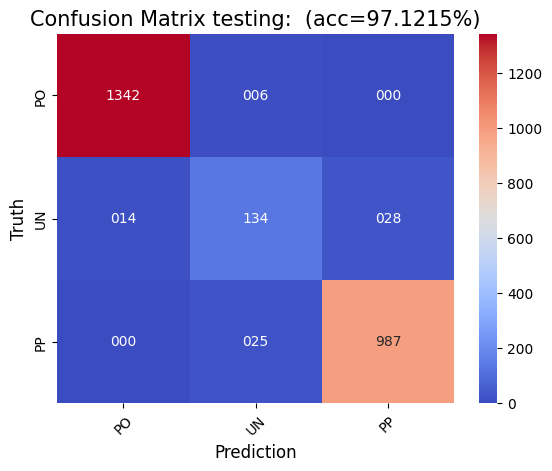

In [22]:
tf_id_vectorizer = TfidfVectorizer(stop_words='english',min_df=0.01,max_df=0.9)
X_train_tweet_tfid = tf_id_vectorizer.fit_transform(X_train_tweet)
X_test_tweet_tfid = tf_id_vectorizer.transform(X_test_tweet)

print("Using TF-IDF")
print("tf-idf shape: ", X_train_tweet_tfid.shape)
X_train_full = np.concatenate((X_train,X_train_tweet_tfid.toarray()),axis=1)
X_test_full = np.concatenate((X_test,X_test_tweet_tfid.toarray()),axis=1)
print("full shape: ",X_train_full.shape)

y_pred_tr, y_pred_te = do_logistic_regression(X_train_full,X_test_full)
evaluate(y_pred_te)


Using Bag of Words
bow shape:  (10142, 220)
full shape:  (10142, 339)


d:\Library\Downloads\Documents\School\SUPSI_23-24\hackathon_2\project\venv\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\Library\Downloads\Documents\School\SUPSI_23-24\hackathon_2\project\venv\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\Library\Downloads\Documents\School\SUPSI_23-24\hackathon_2\project\venv\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\Library\Downloads\Documents\School\SUPSI_23-24\hackathon_2\project\venv\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best parameters found by grid search: {'C': 1, 'penalty': 'l2'}
Classification Report:
               precision    recall  f1-score   support

          PO       0.99      1.00      0.99      1348
          PP       0.82      0.77      0.80       176
          UN       0.97      0.97      0.97      1012

    accuracy                           0.97      2536
   macro avg       0.93      0.91      0.92      2536
weighted avg       0.97      0.97      0.97      2536



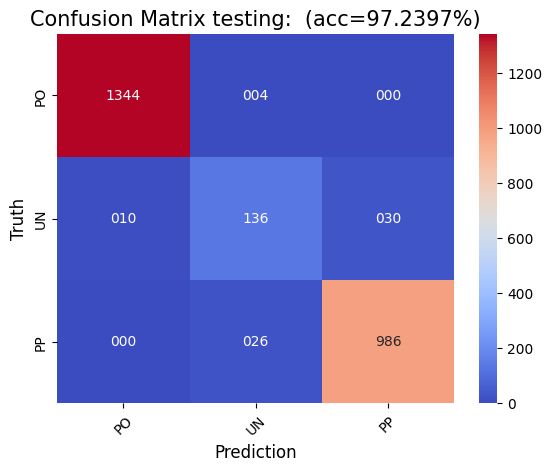

In [23]:
# bag of word
cnt_vectorizer = CountVectorizer(stop_words='english',min_df=0.01,max_df=0.9)
X_train_bow = cnt_vectorizer.fit_transform(X_train_tweet)
X_test_bow = cnt_vectorizer.transform(X_test_tweet)

print("Using Bag of Words")
print("bow shape: ", X_train_bow.shape)
X_train_full = np.concatenate((X_train,X_train_bow.toarray()),axis=1)
X_test_full = np.concatenate((X_test,X_test_bow.toarray()),axis=1)
print("full shape: ",X_train_full.shape)

y_pred_tr, y_pred_te = do_logistic_regression(X_train_full,X_test_full)
evaluate(y_pred_te)

Using Word2Vec
vec shape:  (10142, 100)
full shape:  (10142, 219)


d:\Library\Downloads\Documents\School\SUPSI_23-24\hackathon_2\project\venv\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\Library\Downloads\Documents\School\SUPSI_23-24\hackathon_2\project\venv\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\Library\Downloads\Documents\School\SUPSI_23-24\hackathon_2\project\venv\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\Library\Downloads\Documents\School\SUPSI_23-24\hackathon_2\project\venv\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\Library\Downloads\Documents\School\SUPSI_23-24\hackathon_2\project\venv\Lib\site-packages\sklearn\svm\_base.p

Best parameters found by grid search: {'C': 100, 'penalty': 'l1'}
Classification Report:
               precision    recall  f1-score   support

          PO       0.98      0.98      0.98      1348
          PP       0.83      0.78      0.80       176
          UN       0.95      0.96      0.95      1012

    accuracy                           0.96      2536
   macro avg       0.92      0.91      0.91      2536
weighted avg       0.96      0.96      0.96      2536



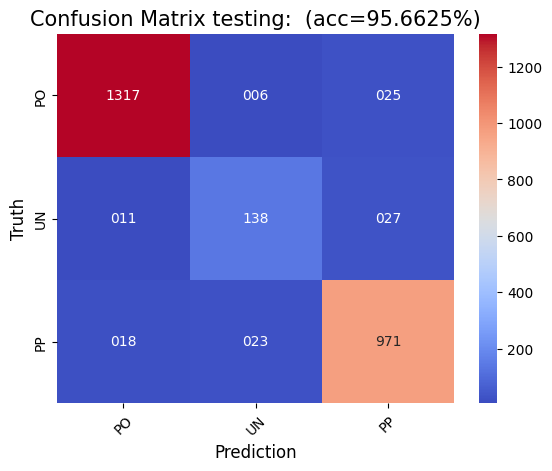

In [24]:
# word2vec
print("Using Word2Vec")
print("vec shape: ", X_train_vec.shape)
X_train_full = np.concatenate((X_train,X_train_vec),axis=1)
X_test_full = np.concatenate((X_test,X_test_vec),axis=1)
print("full shape: ",X_train_full.shape)

y_pred_tr, y_pred_te = do_logistic_regression(X_train_full,X_test_full)
evaluate(y_pred_te)

In [25]:
def do_logistic_regression(X_tr,X_te):
    # Setting up the logistic regression model
    logreg = LogisticRegression(solver='liblinear', multi_class='auto')

    # Defining the parameter grid for grid search
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2']
    }

    # Performing grid search with 5-fold cross-validation
    grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_tr, y_train)

    # Best parameters found by grid search
    best_params = grid_search.best_params_
    print('Best parameters found by grid search:', best_params)

    # Training the model with the best parameters
    best_model = grid_search.best_estimator_

    # Predicting on both training and testing sets
    y_pred_train = best_model.predict(X_tr)
    y_pred_test = best_model.predict(X_te)

    return y_pred_train,y_pred_test
        

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Function to perform grid search and model fitting using Random Forest
def do_randomforest(X_tr, X_te):
    # Setting up the Random Forest model
    rf = RandomForestClassifier()

    # Defining the parameter grid for grid search
    param_grid = {
        'n_estimators': [10, 50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    # Performing grid search with 5-fold cross-validation
    grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_tr, y_train)

    # Best parameters found by grid search
    best_params = grid_search.best_params_
    print('Best parameters found by grid search:', best_params)

    # Training the model with the best parameters
    best_model = grid_search.best_estimator_

    # Predicting on both training and testing sets
    y_pred_train = best_model.predict(X_tr)
    y_pred_test = best_model.predict(X_te)

    return y_pred_train, y_pred_test

Using TF-IDF
tf-idf shape:  (10142, 220)
full shape:  (10142, 339)
Best parameters found by grid search: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Classification Report:
               precision    recall  f1-score   support

          PO       0.99      1.00      0.99      1348
          PP       0.88      0.64      0.74       176
          UN       0.95      0.99      0.97      1012

    accuracy                           0.97      2536
   macro avg       0.94      0.88      0.90      2536
weighted avg       0.97      0.97      0.97      2536



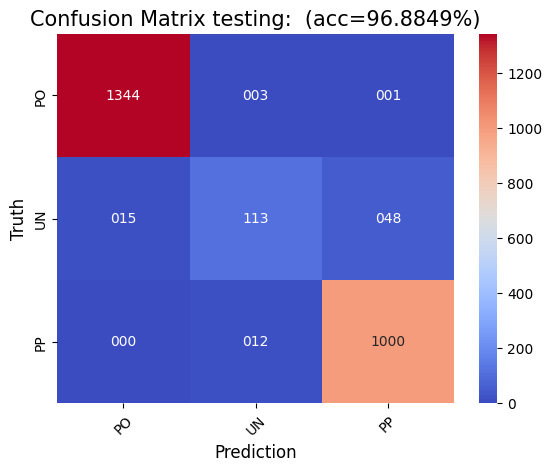

In [27]:
print("Using TF-IDF")
print("tf-idf shape: ", X_train_tweet_tfid.shape)
X_train_full = np.concatenate((X_train,X_train_tweet_tfid.toarray()),axis=1)
X_test_full = np.concatenate((X_test,X_test_tweet_tfid.toarray()),axis=1)
print("full shape: ",X_train_full.shape)

y_pred_tr, y_pred_te =do_randomforest(X_train_full, X_test_full)
evaluate(y_pred_te)

Using Bag of Words
bow shape:  (10142, 220)
full shape:  (10142, 339)
Best parameters found by grid search: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Classification Report:
               precision    recall  f1-score   support

          PO       0.99      1.00      0.99      1348
          PP       0.87      0.64      0.74       176
          UN       0.95      0.99      0.97      1012

    accuracy                           0.97      2536
   macro avg       0.94      0.87      0.90      2536
weighted avg       0.97      0.97      0.97      2536



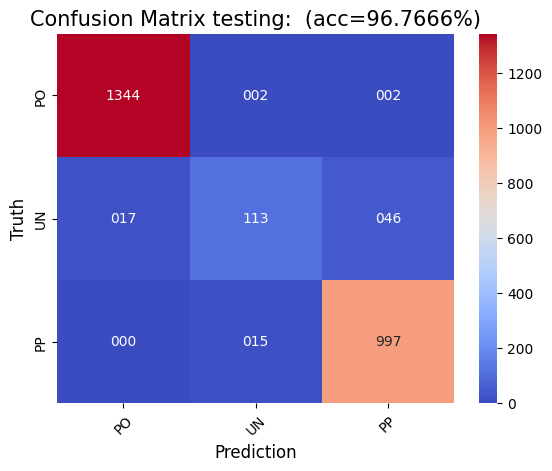

In [28]:
# bag of word
print("Using Bag of Words")
print("bow shape: ", X_train_bow.shape)
X_train_full = np.concatenate((X_train,X_train_bow.toarray()),axis=1)
X_test_full = np.concatenate((X_test,X_test_bow.toarray()),axis=1)
print("full shape: ",X_train_full.shape)

y_pred_tr, y_pred_te =do_randomforest(X_train_full, X_test_full)
evaluate(y_pred_te)

Using Word2Vec
vec shape:  (10142, 100)
full shape:  (10142, 219)
Best parameters found by grid search: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Classification Report:
               precision    recall  f1-score   support

          PO       0.96      0.99      0.97      1348
          PP       0.86      0.68      0.76       176
          UN       0.95      0.94      0.94      1012

    accuracy                           0.95      2536
   macro avg       0.92      0.87      0.89      2536
weighted avg       0.95      0.95      0.95      2536



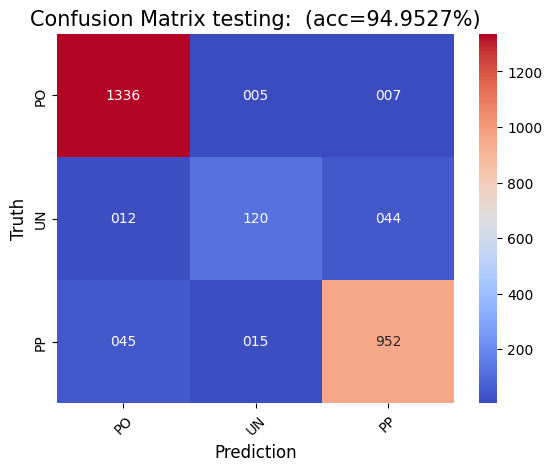

In [29]:
# word2vec
print("Using Word2Vec")
print("vec shape: ", X_train_vec.shape)
X_train_full = np.concatenate((X_train,X_train_vec),axis=1)
X_test_full = np.concatenate((X_test,X_test_vec),axis=1)
print("full shape: ",X_train_full.shape)

y_pred_tr, y_pred_te =do_randomforest(X_train_full, X_test_full)
evaluate(y_pred_te)